# Snake

In [1]:
from environments import *
from IPython.display import clear_output
from  tqdm import trange
import matplotlib.pyplot as plt
import os
from replay_memory import *
from models import *
import json
import random
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
LOAD_FROM_MEMORY = False

## Environment definition

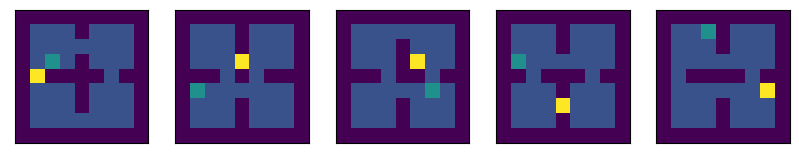

In [3]:
def get_env(n=1000):
    return Walls9x9SnakeEnvironment(n)
env_ = get_env()
GAMMA = .9
ITERATIONS = 5000
RESET_EVERY_N = 100
# 10 random iterations, 100 elements from each of them
replay_memory = ReplayMemoryFast(1000, 10, 100)

fig,axs=plt.subplots(1,min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")

## Model

In [4]:
class EpsGreedyPolicy:
    def __init__(self, exp_iter=ITERATIONS*4/5, min_eps=0.01):
        self.iter = 0
        self.exp_iter = exp_iter
        self.min_eps = min_eps
    def sample(self, q_values):
        # linear decay from uniform to eps-greedy with eps being self.min_eps
        eps = max(0.75-self.iter / self.exp_iter, self.min_eps)
        self.iter += 1
        probs = np.ones_like(q_values) * eps/3.
        np.put_along_axis(probs, np.argmax(q_values, axis=-1)[..., None], 1-eps, axis=1)
        probs = tf.linalg.normalize(probs, ord=1, axis=-1)[0]
        return tf.random.categorical(
            np.log(probs), 1
        ).numpy()

class GreedyPolicy:
    def sample(self, q_values):
        return np.argmax(q_values, axis=-1, keepdims=True)

In [5]:
MODELS_PREFIX = f"models/{type(env_).__name__}/{env_.board_size}x{env_.board_size}"
os.makedirs(MODELS_PREFIX, exist_ok=True)

In [7]:
qfunction, avg_rewards = load_models(env_, folder_name=MODELS_PREFIX if LOAD_FROM_MEMORY else None)

In [8]:
qtarget = tf.keras.models.clone_model(
    qfunction
)

## Training

In [9]:
policy = EpsGreedyPolicy()
if LOAD_FROM_MEMORY: # start with the most eps-greedy policy possible, to avoid forgetting
    policy.iter = policy.exp_iter

In [10]:
optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

In [11]:
loss_f = tf.keras.losses.MeanSquaredError()

@tf.function
def train_step(samples, qfunction, qtarget):
    with tf.GradientTape(persistent=True) as tape:
        losses = []
        # for each set of SARS observation, perform regression
        for observation, action, reward, new_observation in samples:
            indexes = tf.range(tf.shape(action)[0], dtype=tf.int64)[..., None]
            q_estimate = qfunction(observation)
            action = tf.concat((indexes, action), axis=-1)
            q_obs = tf.gather_nd(q_estimate, action)[...,None]
            q_new_estimate = qfunction(new_observation)
            q_new_estimate = tf.experimental.numpy.take_along_axis(q_new_estimate, tf.argmax(qtarget(new_observation), axis=-1, output_type=tf.int32)[...,None], axis=1)
            q_target = tf.stop_gradient(reward + GAMMA * q_new_estimate)
            losses.append(loss_f(q_target, q_obs))
        loss = tf.reduce_mean(losses)

    gradient_q = tape.gradient(loss, qfunction.trainable_weights)
    optimizer.apply_gradients(zip(gradient_q, qfunction.trainable_weights))
    return loss

In [12]:
losses = []

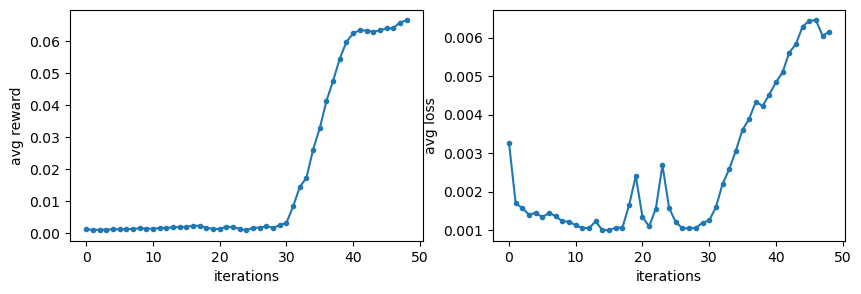

100%|██████████| 5000/5000 [05:35<00:00, 14.89it/s]


In [13]:
for iteration in trange(ITERATIONS):
    # every RESET_EVERY_N reset the target to avoid covariante update
    if iteration % RESET_EVERY_N == 0:
        qtarget.set_weights(qfunction.get_weights())

    # perform a step, store the SARS batch into memory, sample from it
    state = env_.to_state()
    actions = policy.sample(qfunction(env_.to_state()))
    rewards = env_.move(actions)
    new_state = env_.to_state()
    replay_memory.store(state, actions, rewards, new_state)
    samples = replay_memory.sample()

    # if we have enough samples to sample from, start regressing
    if len(samples) >= replay_memory.minibatch_size:
        avg_rewards.append(np.mean(rewards))
        loss = train_step(samples, qfunction, qtarget)
        losses.append(
            loss
        )
    N = 100
    if len(avg_rewards) % N == 0 and len(avg_rewards) > 0:
        # clear output
        clear_output(wait=True)
        points_r = np.array(avg_rewards[:len(avg_rewards)//N*N]).reshape((-1, N)).mean(axis=-1)
        points_t = np.array(losses[:len(losses)//N*N]).reshape((-1, N)).mean(axis=-1)
        fig, axs = plt.subplots(1,2, figsize=(10,3))
        axs[0].plot(points_r, marker=".")
        axs[0].set_xlabel("iterations")
        axs[0].set_ylabel("avg reward")
        axs[1].plot(points_t, marker=".")
        axs[1].set_xlabel("iterations")
        axs[1].set_ylabel("avg loss")
        plt.show()
        # save
        with open(f"{MODELS_PREFIX}/training.txt", "w+") as file:
            json.dump(np.array(avg_rewards).tolist(), file)
        qfunction.save_weights(f"{MODELS_PREFIX}/agent")

 ### Random policy reward

In [14]:
random_env = get_env(100)
random_rewards = []

for _ in trange(1000):
    #sample actions
    actions =  tf.random.categorical(tf.math.log(tf.convert_to_tensor([[.25]*4]*random_env.n_boards)), 1, dtype=tf.int32)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards))

100%|██████████| 1000/1000 [00:02<00:00, 344.87it/s]


## Training evaluation

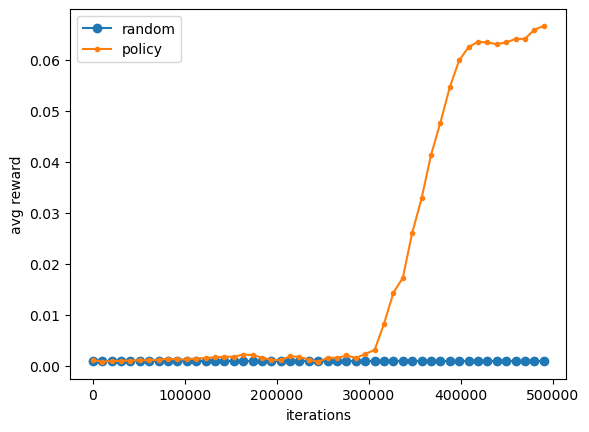

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
CHUNK_SIZE = 100
N = len(avg_rewards)//CHUNK_SIZE*CHUNK_SIZE
x = np.linspace(0,CHUNK_SIZE*N, N//CHUNK_SIZE)
plt.plot(x, np.array(random_rewards[700:]).mean(axis=-1).repeat(N//CHUNK_SIZE), marker="o")
points = np.array(avg_rewards)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)
plt.plot(x, points, marker=".")
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["random", "policy"])